In [4]:
import matplotlib as mpl
# mpl.use('Agg')
from os.path import join
from matplotlib import pyplot as plt

In [6]:
import os
import numpy as np
# os.environ['QT_QPA_FONTDIR']='/home/jgsanders/miniconda/envs/qiime2-2018.6/etc/fonts/conf.d/'
# os.environ['QT_QPA_PLATFORM']='offscreen'

from matplotlib import cm

import skbio
from skbio import TreeNode
from biom import load_table, Table

from io import StringIO

import pandas as pd
import seaborn as sns

from ete3 import Tree, TextFace, TreeStyle, NodeStyle
from qiime2 import Artifact

In [7]:
% matplotlib inline

In [8]:
import subprocess

def qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=8, t='24:00:00', name='nb_qsub',
         o='/dev/null', e='/dev/null'):
    payload = '{0}; {1}'.format(environment, script)
    
    cmd = ('echo "{payload}" | '
           'qsub -k eo -o {o} -e {e} -N {name} '
           '-l nodes=1:ppn={n} -l mem={mem}gb -l '
           'walltime={t}'.format(payload=payload, o=o, e=e, n=n, name=name, mem=mem, t=t))
    
    
    ps = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = ps.communicate()[0]
    
    print(cmd)
    
    return(output)  

# Insertion-constrained phylogeny calculation

This notebook gives an example of insertion-constrained phylogenetic tree insertion for 16S microbial sequences. 

The motivation for microbial tree estimation using constraints derived from phylogenetic insertion is to be able to create a tree of microbial 16S sequence fragments which both 1) conforms to the higher-level topology calculated from better data, and 2) retains as much information as possible about fine-level relationships among sequences. 

This is particularly relevant to problems involving host-microbe association, as it is frequently the case that reference databases will contain a few sequences close to a group of newly-observed host-associated microbes, but not enough to reflect the total amount of host-related diversity within the clade. Consequently, newly-observed sequences will all be inserted with long branches into the same edge on the reference phylogeny.

## Example data and visualization

We'll use a small set of OTUs from a recent publication on host-associated microbes [(Amato *et al.* 2017, *ISMEJ*)](https://www.nature.com/articles/s41396-018-0175-0) to illustrate this phenomenon, and to test our method. 

In [11]:
data_dir = './phylogeny_constraint/data'
output_dir = './phylogeny_constraint/output'

In [12]:
test_otu_fp =join(data_dir, 'test_otus.fasta')
test_otu_tree_fp = join(data_dir, 'test_otus.tre')

In [13]:
!head {test_otu_fp}

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


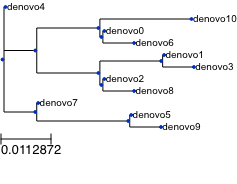

In [14]:
test_otu_tree = Tree(test_otu_tree_fp)

test_otu_tree.render("%%inline")

Now, we'll color these tips by the predominant host group in which they're found.

In [15]:
def highlight_tree(tree, leaf_colors):

    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            color = leaf_colors.get(node.name, None)
            if color:
                name_face = TextFace(node.name, fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    # Draw Tree
    return(tree.render('%%inline',  tree_style=ts))

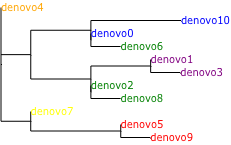

In [16]:
test_otu_tree = Tree(test_otu_tree_fp)

leaf_colors = {'denovo4': 'orange',
              'denovo7': 'yellow',
              'denovo9': 'red',
              'denovo5': 'red',
              'denovo3': 'purple',
              'denovo1': 'purple',
              'denovo8': 'green',
              'denovo2': 'green',
              'denovo10': 'blue',
              'denovo0': 'blue',
              'denovo6': 'green'}

highlight_tree(test_otu_tree, leaf_colors)

In [17]:
def highlight_tree_phyla(tree, leaf_phyla, phylum_colors):

    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            phylum = leaf_phyla.get(node.name, None)
            color = phylum_colors.get(phylum, None)
            if color:
                name_face = TextFace(node.name, fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    # Draw Tree
    return(tree.render('%%inline',  tree_style=ts))

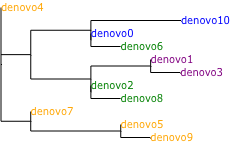

In [18]:
test_otu_tree = Tree(test_otu_tree_fp)

leaf_phyla = {'denovo4': 'p_Firmicutes',
              'denovo7': 'p_Firmicutes',
              'denovo9': 'p_Firmicutes',
              'denovo5': 'p_Firmicutes',
              'denovo3': 'p_Bacteroidetes',
              'denovo1': 'p_Bacteroidetes',
              'denovo8': 'p_Proteobacteria',
              'denovo2': 'p_Proteobacteria',
              'denovo10': 'p_Actinobacteria',
              'denovo0': 'p_Actinobacteria',
              'denovo6': 'p_Proteobacteria'}

phylum_colors = {'p_Firmicutes': 'orange',
              'p_Bacteroidetes': 'purple',
              'p_Proteobacteria': 'green',
              'p_Actinobacteria': 'blue'}

highlight_tree_phyla(test_otu_tree, leaf_phyla, phylum_colors)

Searching these squences against GreenGenes reveals only two hits, which group the two major clades, but fail to resolve any of the variation within clades.

In [19]:
# !vsearch --usearch_global {test_otu_fp} --db {data_dir}/97_otus.fasta.gz --id 0.97 --top_hits_only --blast6out -

We'll try inserting these into the GG phylogeny and see what we get out

In [20]:
test_otu_artifact_fp = join(data_dir, 'test_sequences.qza')

In [21]:
# !qiime tools import --type FeatureData[Sequence] \
# --input-format DNAFASTAFormat \
# --input-path ./phylogeny_constraint/data/test_otus.fasta \
# --output-path {test_otu_artifact_fp}

In [22]:
test_insertion_fp = join(data_dir, 'test_sequences.sepp.tre.qza')
test_placement_fp = join(data_dir, 'test_sequences.sepp.json.qza')

In [23]:
# !qiime fragment-insertion sepp \
# --i-representative-sequences ./phylogeny_constraint/data/test_sequences.qza \
# --o-tree {test_insertion_fp} --o-placements {test_placement_fp}

In [24]:
test_insertion_newick_fp = join(data_dir, 'test_sequences.sepp.tre')

In [25]:
# !qiime tools export --input-path {foofp} \
# --output-path test.fna \
# --output-format DNAFASTAFormat

In [26]:
!head test.fna

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


In [27]:
# !qiime tools export --input-path {test_insertion_fp} \
# --output-path {test_insertion_newick_fp} \
# --output-format NewickFormat

In [28]:
# Importing newick tree

In [29]:
insert_tree = TreeNode.read(test_insertion_newick_fp)

In [30]:
inserted_subtree = insert_tree.lca(leaf_colors.keys())

In [31]:
inserted_subtree_fp = join(data_dir, 'test_sequences.sepp.subtree.tre')

inserted_subtree.write(inserted_subtree_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.tre'

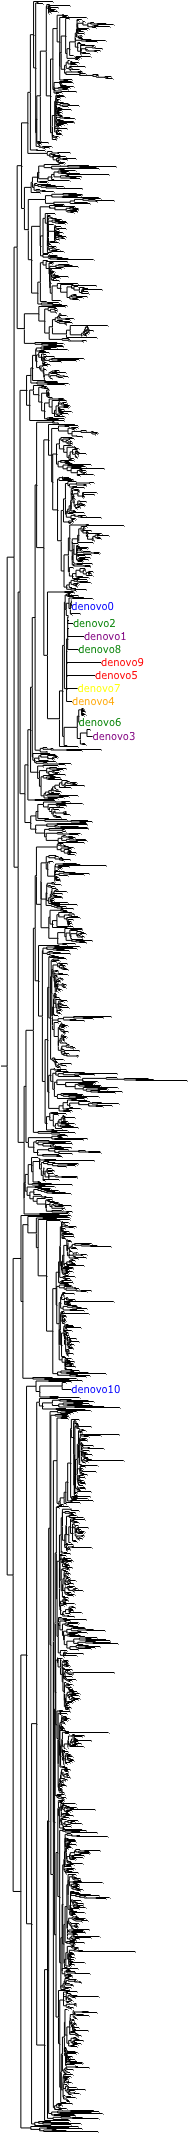

In [32]:
highlight_tree(Tree(inserted_subtree_fp), leaf_colors)

If we trim this down to just the tips we inserted, we can see how much of the internal structure has been removed in the insertion process:

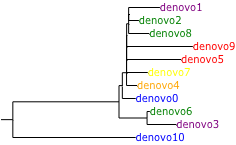

In [33]:
subtree_only = inserted_subtree.shear(leaf_colors.keys())

subtree_only_fp = join(data_dir, 'test_sequences.sepp.subtree.only.tre')

subtree_only.write(subtree_only_fp)

highlight_tree(Tree(subtree_only_fp), leaf_colors)

In [34]:
!head {subtree_only_fp}

(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221):0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denovo0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.020793730000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;


## Collapse nodes in insertion tree

The sheared insertion tree is still bifurcating, even if many of the branches are meaningless. We'll write some code to collapse the nodes of the tree up to a given width. 

In [35]:
test_nwk = ('(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221)'
            ':0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e'
            '-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denov'
            'o0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.0207937'
            '30000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;\n')

exp_nwk = ('((denovo1:0.0221287,denovo2:0.00726798,denovo8:0.0146221'
            ',denovo9:0.0468179,denovo5:0.0386087'
            ',denovo7:0.0149922,denovo4:0.007454,denov'
            'o0:0.00947843352,denovo6:0.00197690352,denovo3:0.0207937'
            '30000000003):0.07509018,denovo10:0.08689025):0.00837201;\n')

from io import StringIO

test_tree = TreeNode.read(StringIO(test_nwk))
exp_tree = TreeNode.read(StringIO(exp_nwk))

def collapse_nodes_to_width(in_tree, max_width=0.1, inplace=False):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.width = node.get_max_distance()[0]

    for node in tree.postorder():
        if node.width < max_width:
            tips = [x for x in node.tips()]

            while len(node.children) > 0:
                node.remove(node.children[0])
                
            for x in tips:
                node.append(x)
        delattr(node, 'MaxDistTips')

    return(tree)

obs_tree = collapse_nodes_to_width(test_tree, max_width=0.1)

assert(obs_tree.compare_rfd(exp_tree) == 0)
assert(obs_tree.compare_tip_distances(exp_tree) == 0)

In [36]:
test_nwk_len = ('((denovo1:0.0,denovo2:0.0,denovo8:0.0,denovo9:0.0,denovo5:0.0,denovo7:0.0'
           ',denovo4:0.0,denovo0:0.0,denovo6:0.0,denovo3:0.0)"foo":0.07509018,denovo10:0.08'
           '689025):0.00837201;\n')

exp_nwk_nolen = ('((denovo1,denovo2,denovo8,denovo9,denovo5,denovo7'
                 ',denovo4,denovo0,denovo6,denovo3),denovo10);\n')

test_tree_len = TreeNode.read(StringIO(test_nwk_len))
exp_tree_nolen = TreeNode.read(StringIO(exp_nwk_nolen))

def remove_branch_lengths_names(in_tree):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.length = None
        if not node.is_tip():
            node.name = None
    return(tree)

obs_tree_nolen = remove_branch_lengths_names(test_tree_len)

assert(obs_tree_nolen.compare_rfd(exp_tree_nolen) == 0)

nodenames = []
nodelens = []
for n in obs_tree_nolen.postorder():
    nodelens.append(n.length)
    if not n.is_tip():
        nodenames.append(n.name)

assert(set(nodenames) == set(nodelens) == {None})


In [37]:
test_nwk_root = ('(((denovo6,denovo3),denovo10),((denovo1,denovo2,denovo8,denovo9),denovo5,denovo7'
                 ',denovo4,denovo0));\n')

exp_nwk_unroot = ('(((denovo1,denovo2,denovo8,denovo9),denovo5,denovo7'
                 ',denovo4,denovo0),(denovo6,denovo3),denovo10);\n')


test_tree_root = TreeNode.read(StringIO(test_nwk_root))
exp_tree_unroot = TreeNode.read(StringIO(exp_nwk_unroot))

def unroot(in_tree):
    tree = in_tree.copy()
    for n in tree.children[0].children:
        if not n.is_tip():
            tree.append(n)
    tree.prune()
    return(tree)

obs_tree_unrooted = unroot(test_tree_root)

assert(obs_tree_unrooted.compare_rfd(exp_tree_unroot) == 0)

## Run IQ-TREE with constraints

In [38]:
test_constraint_collapsed = collapse_nodes_to_width(subtree_only)
test_constraint_nolen = remove_branch_lengths_names(test_constraint_collapsed)
test_constraint_tree = unroot(test_constraint_nolen)

In [39]:
print(test_constraint_tree.ascii_art())

                    /-denovo1
                   |
                   |--denovo2
                   |
                   |--denovo8
                   |
                   |--denovo9
                   |
                   |--denovo5
          /--------|
         |         |--denovo7
         |         |
         |         |--denovo4
         |         |
---------|         |--denovo0
         |         |
         |         |--denovo6
         |         |
         |          \-denovo3
         |
          \-denovo10


In [40]:
obs_constraint_fp = join(data_dir, 'test_sequences.sepp.subtree.only.constraint.tre')
test_constraint_tree.write(obs_constraint_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre'

In [41]:
test_otu_aln_fp = join(data_dir, 'test_otus.aln.fasta')

In [42]:
%%capture
# mafft align sequences

!mafft {test_otu_fp} > {test_otu_aln_fp}

In [43]:
%%capture

# run IQ-TREE without constraints
!iqtree -nt 1 -s ./phylogeny_constraint/data/test_otus.aln.fasta \
-m TIM2+I+G \
-pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.unconstrained

In [44]:
%%capture

# run IQ-TREE with constraints
!iqtree -nt 1 -s ./phylogeny_constraint/data/test_otus.aln.fasta \
-m TIM2+I+G -g ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre \
-pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constrained

We can see that we have now recovered substantial structure within our group of sequences, better reflecting our initial estimate:

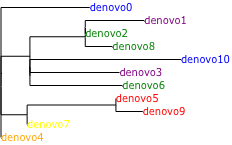

In [45]:
highlight_tree(Tree(join(data_dir, 'test_sequences.sepp.subtree.only.constrained.treefile')), leaf_colors)

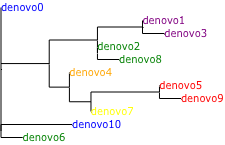

In [46]:
highlight_tree(Tree(join(data_dir, 'test_sequences.sepp.subtree.only.unconstrained.treefile')), leaf_colors)

Compared to the initial estimate, which was calculated from a *de novo* alignment of just the sequences in this clade:

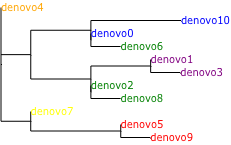

In [47]:
test_otu_tree = Tree(test_otu_tree_fp)

highlight_tree(test_otu_tree, leaf_colors)

And compared to the structure observed from just the insertion tree:

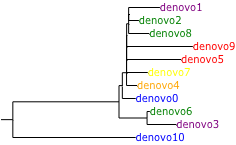

In [48]:
highlight_tree(Tree(subtree_only_fp), leaf_colors)

## Test on larger data set

We'll load the complete dataset of deblurred sequences from the folivore study, and compare different ways of exploring them.

Load biom file of deblurred seqs

In [49]:
primates_biom_fp = join(data_dir, 'primates.deblur.biom')
primates_biom = load_table(primates_biom_fp)

Export seqs

In [50]:
primates_biom.metadata(axis='observation')[23]['taxonomy'][:1][-1]

'k__Bacteria'

In [51]:
primates_seqs = primates_biom.ids(axis='observation')

primates_seqs_fp = join(data_dir, 'primates.seqs.fna')

taxa_dict = {}

with open(primates_seqs_fp, 'w') as f:
    for i, s in enumerate(primates_seqs):
        taxa_dict[s] = primates_biom.metadata(axis='observation')[i]['taxonomy'][:2][-1]
        f.write('>{0}\n{0}\n'.format(s))


Align with mafft, make de novo tree with iq-tree

In [52]:
print('There are a total of %s sequences' % i)

There are a total of 6083 sequences


In [53]:
primate_aln_fp = join(data_dir, 'primates.seqs.aln.fasta')

In [54]:
# for running locally

# %%capture
# mafft align sequences

# !mafft {primates_seqs_fp} > {primate_aln_fp}

In [55]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'mafft --thread 16 {primates_seqs_fp} > {primate_aln_fp}'.format(
            primates_seqs_fp=primates_seqs_fp,
            primate_aln_fp=primate_aln_fp))


qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=16, t='24:00:00', name='nb_mafft',
         o='./mafft_primates.out', e='./mafft_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; mafft --thread 16 ./phylogeny_constraint/data/primates.seqs.fna > ./phylogeny_constraint/data/primates.seqs.aln.fasta" | qsub -k eo -o ./mafft_primates.out -e ./mafft_primates.err -N nb_mafft -l nodes=1:ppn=16 -l mem=32gb -l walltime=24:00:00


b'/bin/sh: qsub: command not found\n'

In [56]:
# for running locally

# %%capture
# run IQ-TREE de novo


# !iqtree -nt 3 -s {primate_aln_fp} \
# -m TIM2+I+G \
# -pre ./phylogeny_constraint/data/primates.seqs.aln.denovo

In [57]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'iqtree -nt 16 -s {primate_aln_fp} '
          '-m TIM2+I+G '
          '-pre ./phylogeny_constraint/data/primates.seqs.aln.denovo'.format(
            primate_aln_fp=primate_aln_fp))

qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=16, t='24:00:00', name='nb_iqtree',
         o='./iqtree_denovo_primates.out', e='./iqtree_denovo_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; iqtree -nt 16 -s ./phylogeny_constraint/data/primates.seqs.aln.fasta -m TIM2+I+G -pre ./phylogeny_constraint/data/primates.seqs.aln.denovo" | qsub -k eo -o ./iqtree_denovo_primates.out -e ./iqtree_denovo_primates.err -N nb_iqtree -l nodes=1:ppn=16 -l mem=32gb -l walltime=24:00:00


b'/bin/sh: qsub: command not found\n'

make insertion tree with SEPP

In [58]:
primates_seqs_art_fp = join(data_dir, 'primates.seqs.fna.qza')

In [59]:
# !qiime tools import --type FeatureData[Sequence] \
# --input-format DNAFASTAFormat \
# --input-path {primates_seqs_fp} \
# --output-path {primates_seqs_art_fp}

In [60]:
primate_insertion_fp = join(data_dir, 'primates.sepp.tre.qza')
primate_placement_fp = join(data_dir, 'primates.sepp.json.qza')

In [61]:
# for running locally

# !qiime fragment-insertion sepp \
# --i-representative-sequences {primates_seqs_art_fp} \
# --o-tree {primate_insertion_fp} --o-placements {primate_placement_fp}

In [62]:
# for running on a remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'qiime fragment-insertion sepp '
          '--p-threads 20 '
          '--i-representative-sequences {primates_seqs_art_fp} '
          '--o-tree {primate_insertion_fp} --o-placements {primate_placement_fp}').format(
          primates_seqs_art_fp=primates_seqs_art_fp,
          primate_insertion_fp=primate_insertion_fp,
          primate_placement_fp=primate_placement_fp)

qsub(script, environment='source activate qiime2-2018.6',
         mem=160, n=20, t='24:00:00', name='nb_sepp',
         o='./sepp_primates.out', e='./sepp_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; qiime fragment-insertion sepp --p-threads 20 --i-representative-sequences ./phylogeny_constraint/data/primates.seqs.fna.qza --o-tree ./phylogeny_constraint/data/primates.sepp.tre.qza --o-placements ./phylogeny_constraint/data/primates.sepp.json.qza" | qsub -k eo -o ./sepp_primates.out -e ./sepp_primates.err -N nb_sepp -l nodes=1:ppn=20 -l mem=160gb -l walltime=24:00:00


b'/bin/sh: qsub: command not found\n'

show de novo tree and color by assigned phylum

In [63]:
primate_denovo_tree_fp = './phylogeny_constraint/data/primates.seqs.aln.denovo.treefile'

In [64]:
colors = [cm.Spectral(i) for i in np.linspace(0, 0.9, len(set(taxa_dict.values())))]

In [65]:
colors_rgb = [mpl.colors.rgb2hex(x) for x in colors]

In [66]:
phylum_colors = dict(zip(list(set(taxa_dict.values())), colors_rgb))

In [67]:
phylum_colors['Unclassified'] = '#bbbbbb'
phylum_colors['k__Bacteria'] = '#dddddd'

In [68]:
def highlight_tree_phyla(tree, leaf_phyla, phylum_colors, midpoint_root=True):
    if midpoint_root:
        R = tree.get_midpoint_outgroup()
        # and set it as tree outgroup
        tree.set_outgroup(R)
    
    style = NodeStyle()
    style['size'] = 0
    tree.set_style(style)
    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            phylum = leaf_phyla.get(node.name, None)
            color = phylum_colors.get(phylum, None)
            if color:
                node.length = 0.2
                nstyle = NodeStyle()
                nstyle["vt_line_color"] = color
                nstyle["hz_line_color"] = color
                nstyle['size'] = 5
                nstyle['bgcolor'] = color
                nstyle['fgcolor'] = color
                node.set_style(nstyle)
                name_face = TextFace('-------', fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    ts.mode = "c"
    # Draw Tree
    return(tree.render('%%inline', w=360, units="mm", tree_style=ts))

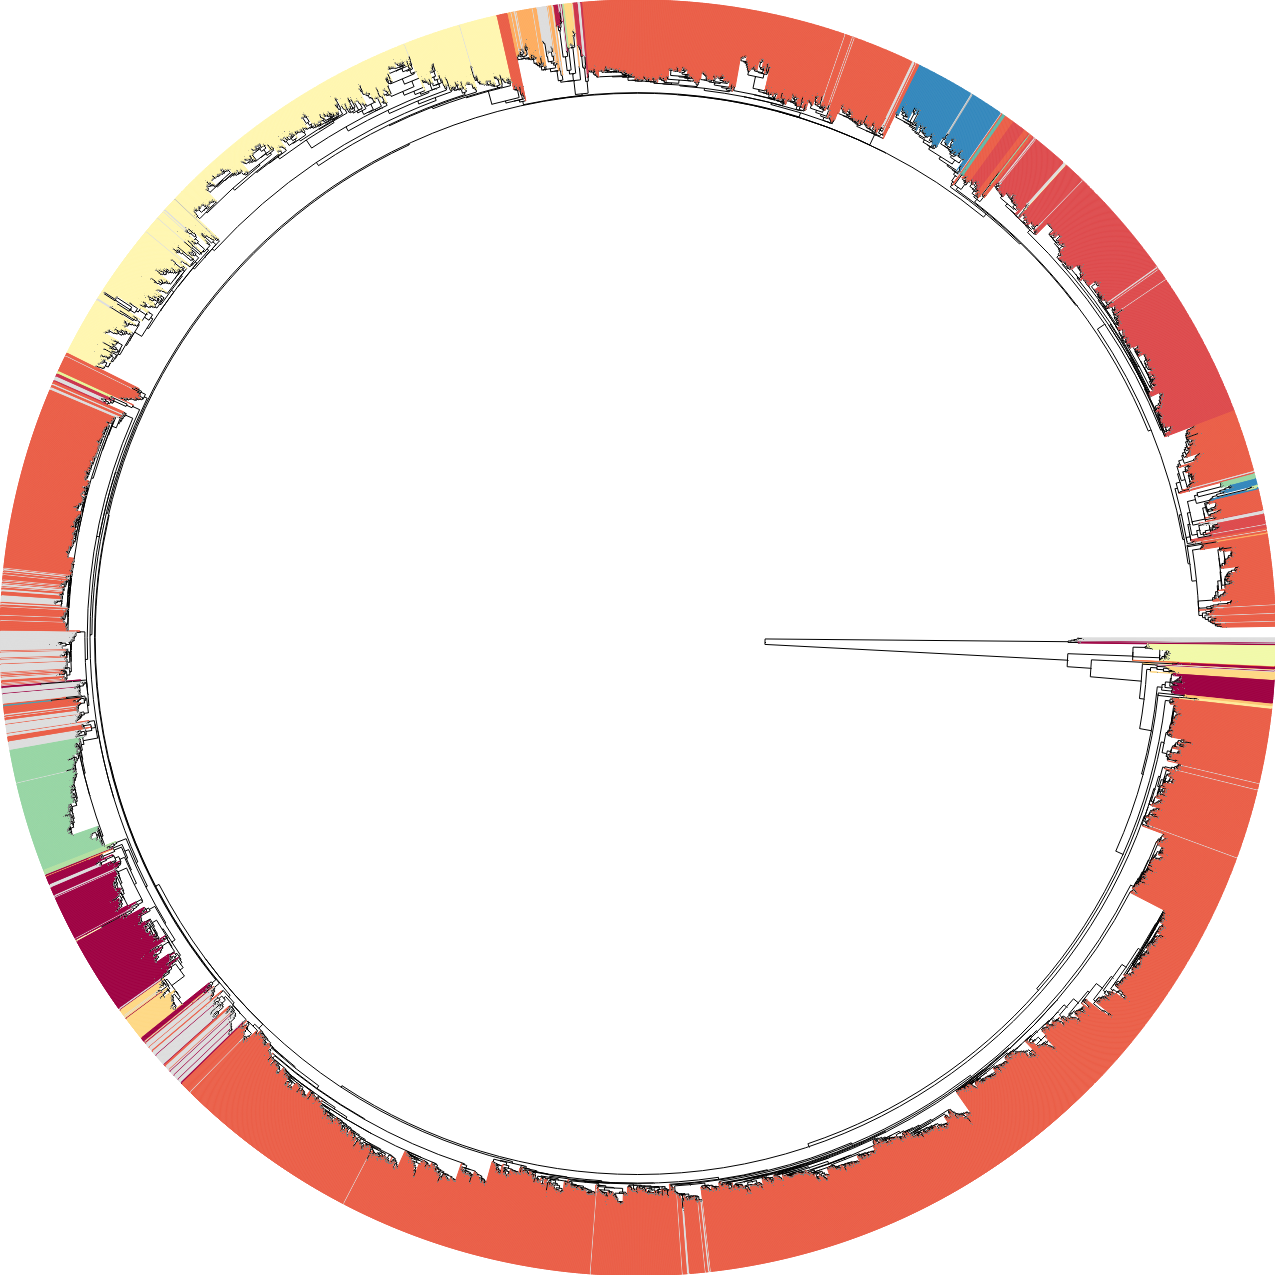

In [69]:
test_otu_tree = Tree(primate_denovo_tree_fp)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

show filtered insertion tree and color by assigned phylum

In [70]:
primate_insertion_fp

'./phylogeny_constraint/data/primates.sepp.tre.qza'

In [71]:
primate_insertion_nwk_fp = join(data_dir, 'primates.sepp.tre')

In [72]:
# !qiime tools export --input-path {primate_insertion_fp} \
# --output-path {primate_insertion_nwk_fp} \
# --output-format NewickFormat

In [73]:
primate_insert_tree = TreeNode.read(primate_insertion_nwk_fp)

primate_inserted_subtree = primate_insert_tree.shear(taxa_dict.keys())

primate_inserted_subtree_fp = join(data_dir, 'primates.sepp.subtree.tre')

primate_inserted_subtree.write(primate_inserted_subtree_fp)

'./phylogeny_constraint/data/primates.sepp.subtree.tre'

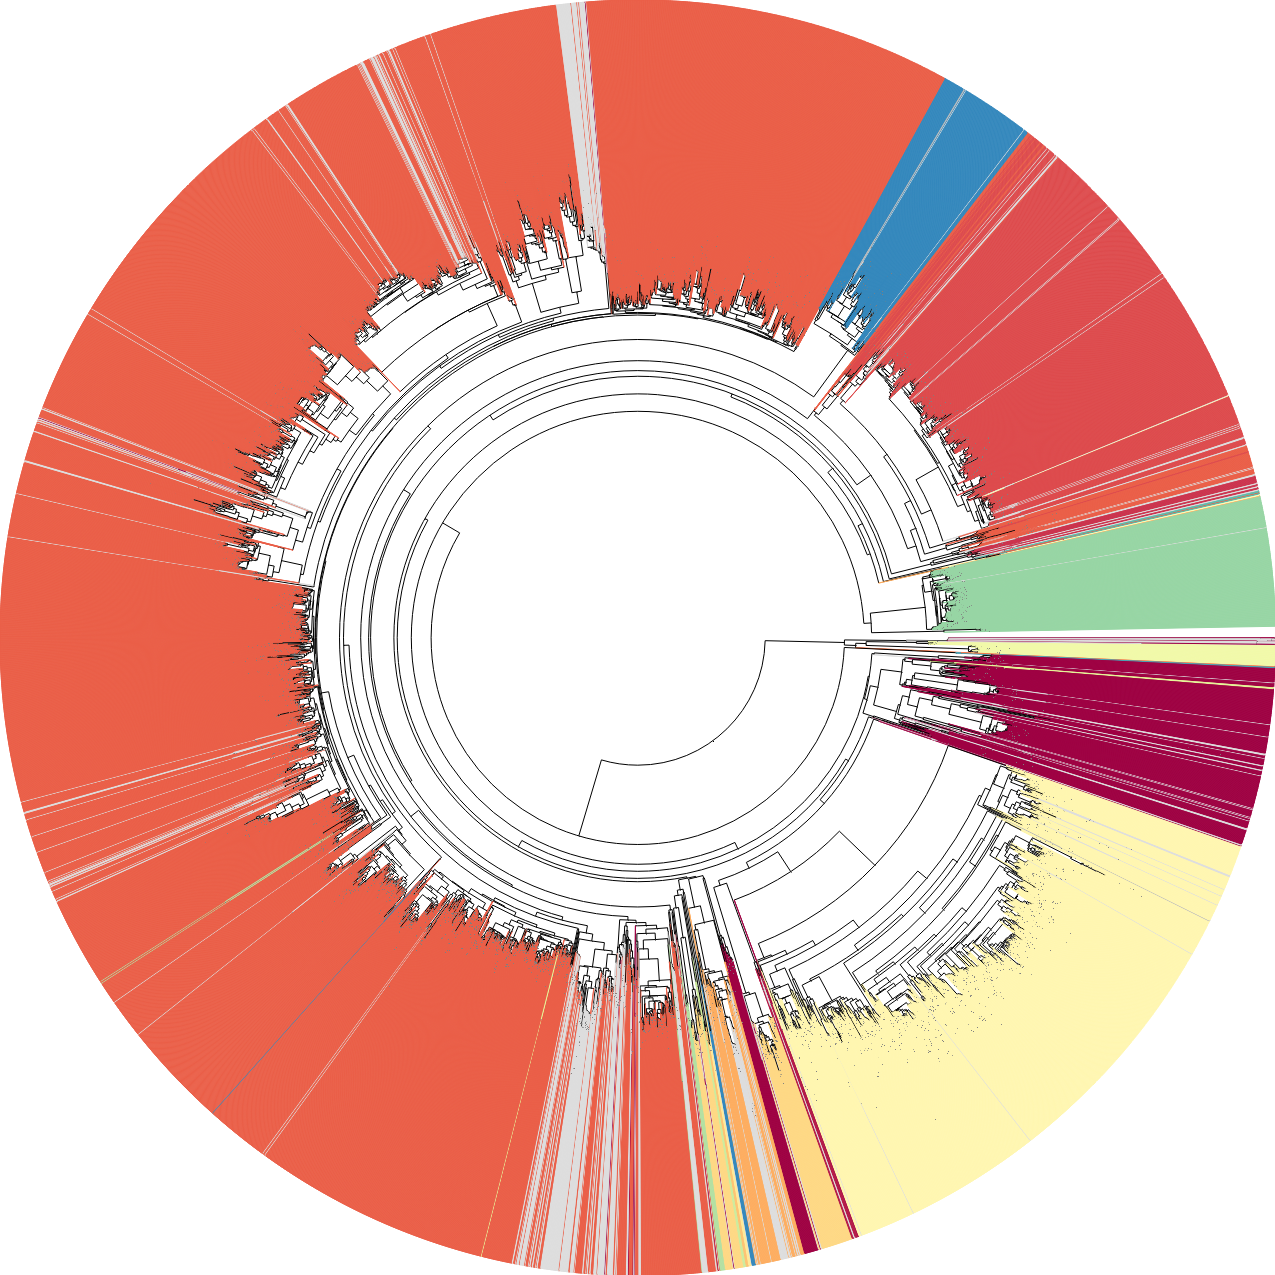

In [74]:
test_otu_tree = Tree(primate_inserted_subtree_fp, format=1, quoted_node_names=True)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

### make constraint tree and rerun with constrained IQ-TREE

In [75]:
primate_constraint_tree = collapse_nodes_to_width(primate_inserted_subtree, max_width=0.2)
primate_constraint_tree = remove_branch_lengths_names(primate_constraint_tree)
unrooted_constraint_tree = unroot(primate_constraint_tree)

In [76]:
primate_constraint_fp = join(data_dir, 'primates.sepp.subtree.constraint.tre')

In [77]:
primate_constraint_tree.write(primate_constraint_fp)

'./phylogeny_constraint/data/primates.sepp.subtree.constraint.tre'

In [78]:
unrooted_constraint_fp = join(data_dir, 'primates.sepp.subtree.constraint.unrooted.tre')

In [79]:
unrooted_constraint_tree.write(unrooted_constraint_fp)

'./phylogeny_constraint/data/primates.sepp.subtree.constraint.unrooted.tre'

Visualize constraint tree

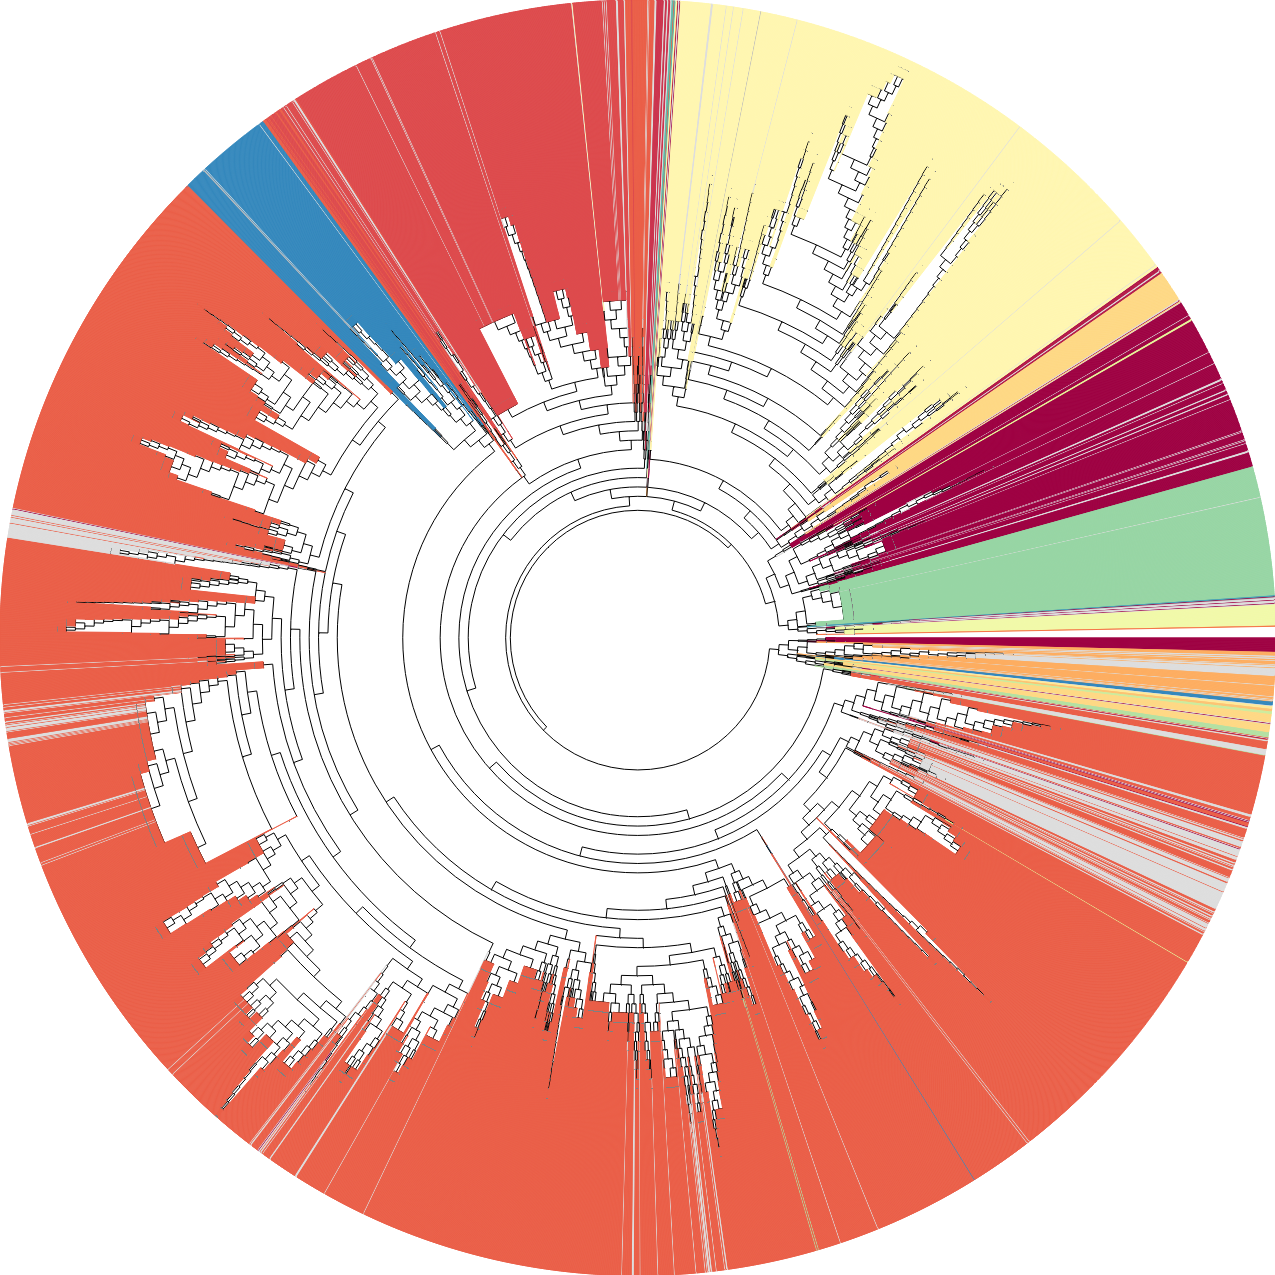

In [80]:
test_otu_tree = Tree(unrooted_constraint_fp, format=1, quoted_node_names=True)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

In [81]:
# # # for running locally

# # %%capture
# # run IQ-TREE with constraints
# !iqtree -nt 1 -s {primate_aln_fp} \
# -m TIM2+I+G -g {primate_constraint_fp} \
# -pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained

In [82]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'iqtree --version; '
          'iqtree -nt 16 -s {primate_aln_fp} '
          '-m TIM2+I+G -g {constraint_fp} '
          '-pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained'.format(
            primate_aln_fp=primate_aln_fp,
            constraint_fp=unrooted_constraint_fp))

qsub(script, environment='source activate iqtree',
         mem=32, n=16, t='72:00:00', name='nb_iqtree-b',
         o='./iqtree_const_primates.beta.out', e='./iqtree_const_primates.beta.err')

echo "source activate iqtree; cd /home/jgsanders/git_sw/q2-fragment-insertion; iqtree --version; iqtree -nt 16 -s ./phylogeny_constraint/data/primates.seqs.aln.fasta -m TIM2+I+G -g ./phylogeny_constraint/data/primates.sepp.subtree.constraint.unrooted.tre -pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained" | qsub -k eo -o ./iqtree_const_primates.beta.out -e ./iqtree_const_primates.beta.err -N nb_iqtree-b -l nodes=1:ppn=16 -l mem=32gb -l walltime=72:00:00


b'/bin/sh: qsub: command not found\n'

Visualizing the recomputed, constrained tree:

In [83]:
recomputed_tree_fp = join(data_dir, './primates.sepp.subtree.constrained.treefile')

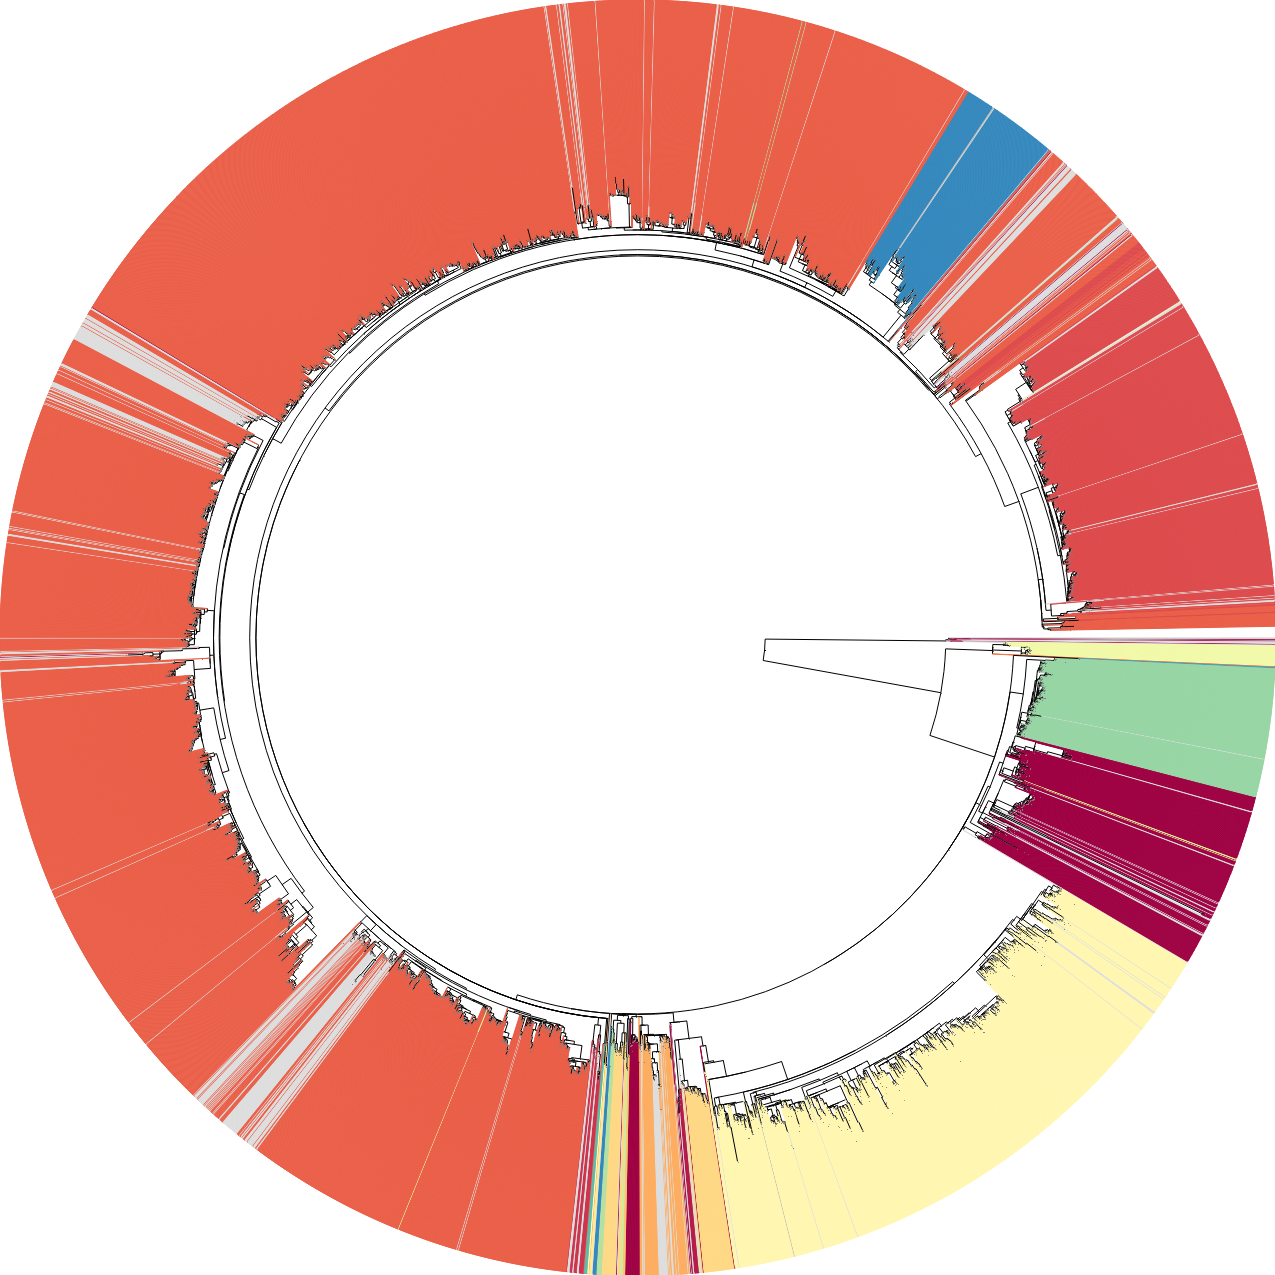

In [84]:
test_otu_tree = Tree(recomputed_tree_fp, format=1, quoted_node_names=True)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

How did our target sequences fare?

In [85]:
test_otu_fp

'./phylogeny_constraint/data/test_otus.fasta'

In [86]:
import skbio

In [87]:
seq_dict = {}
for seq in skbio.io.read(test_otu_fp, format='fasta'):
    seq_dict[str(seq)] = seq.metadata['id']


In [88]:
seq_dict

{'TACGTAGGTAGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG': 'denovo4',
 'TACGTAGGTAGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG': 'denovo7',
 'TACGTAGGTAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGAACTGCATTTGAAACCGTCTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTGG': 'denovo9',
 'TACGTAGGTAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTGG': 'denovo5',
 'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG': 'denovo10',
 'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCATTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG': 'denovo8',
 'T

In [89]:
recomputed_tree = TreeNode.read(recomputed_tree_fp)

In [90]:
recomputed_tree

<TreeNode, name: unnamed, internal node count: 6081, tips count: 6084>

In [91]:
subset_tree = recomputed_tree.shear(seq_dict.keys())

for n in subset_tree.postorder():
    if n.name in seq_dict:
        n.name = seq_dict[n.name]

In [92]:
ids_to_keep = ['denovo9', 'denovo1', 'denovo7',
               'denovo6', 'denovo5', 'denovo2',
               'denovo0', 'denovo4', 'denovo8',
               'denovo3']

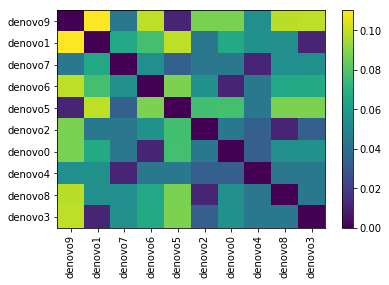

In [93]:
subset_dists = subset_tree.tip_tip_distances()
subset_dists = subset_dists.filter(ids_to_keep)
subset_dists

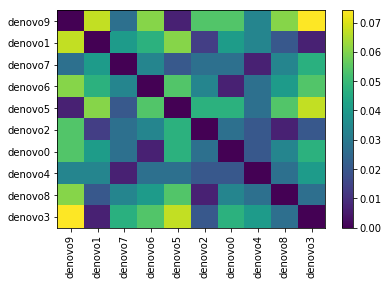

In [94]:
orig_tree = TreeNode.read(test_otu_tree_fp)
orig_dists = orig_tree.tip_tip_distances()
orig_dists = orig_dists.filter(ids_to_keep)
orig_dists

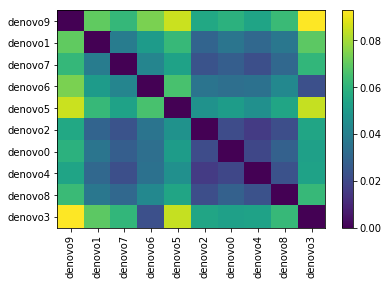

In [95]:
sepp_tree = TreeNode.read(subtree_only_fp)
sepp_dists = sepp_tree.tip_tip_distances()
sepp_dists = sepp_dists.filter(ids_to_keep)
sepp_dists

In [96]:
import pandas as pd
import seaborn as sns

In [97]:
all_dists = pd.concat([orig_dists.to_series(),
                       sepp_dists.to_series(),
                       subset_dists.to_series()], axis=1)
all_dists.columns = ['original','sepp','constrained']

Ignoring denovo10, which ends up as an outgroup based on the insertion tree, we get a quite a bit tighter relationship in branch lengths between the original and the constrained and recomputed tree than with the raw SEPP insertion tree: 

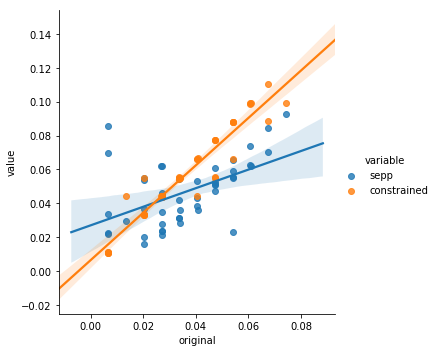

In [98]:
sns.lmplot(x="original", y="value", hue="variable", data=pd.melt(all_dists, id_vars = ['original']));

They are also closer for Robinson-Fould distance, as well as considering a distance metric of tip to tip distance matrix:

In [99]:
sepp_tree.compare_rfd(orig_tree.shear(ids_to_keep), proportion=True)

1.0

In [100]:
subset_tree.compare_rfd(orig_tree.shear(ids_to_keep), proportion=True)

0.2

In [101]:
sepp_tree.compare_tip_distances(orig_tree.shear(ids_to_keep))

0.16402167505381871

In [102]:
subset_tree.compare_tip_distances(orig_tree.shear(ids_to_keep))

0.016887991389712698

Testing against the input trees:

In [103]:
primate_denovo_tree = TreeNode.read(primate_denovo_tree_fp)

In [104]:
primate_inserted_subtree = TreeNode.read(primate_inserted_subtree_fp)

In [105]:
unrooted_constraint_tree = TreeNode.read(unrooted_constraint_fp)

In [106]:
constraint_tree = TreeNode.read(primate_constraint_fp)

In [107]:
recomputed_tree.compare_rfd(primate_denovo_tree)

9330.0

In [108]:
recomputed_tree.compare_rfd(primate_inserted_subtree)

5245.0

In [109]:
recomputed_tree.compare_rfd(unrooted_constraint_tree)

3602.0

In [110]:
recomputed_tree.compare_tip_distances(primate_denovo_tree)

0.14483525016422055

In [111]:
recomputed_tree.compare_tip_distances(primate_inserted_subtree)

0.0384403217638703

In [112]:
?primate_denovo_tree.lowest_common_ancestor

In [141]:
def find_paraphyly(tree1, tree2, limit=10000, start=0):
    a = []
    b = []
    for i, node in enumerate(tree1.postorder()):
        if start:
            if i < start:
                continue
                
        if i % 100 == 0:
            print("Checking node %s..." % i)
        if node.is_tip():
            continue
        tips = [x.name for x in node.tips()]
        
        b_node = tree2.lca(tips)

        if set(tips) != set([x.name for x in b_node.tips()]):
            print("Found paraphyletic node at node %s!" % i)
            a.append(node)
            b.append(b_node)
            
        if i > limit:
            print("Reached limit without paraphyly")
    
    if a == b == []:
        print("None found")
        return(None, None)
    else:
        num = len(a)
        print("Found %s paraphyletic nodes!" % num)
        return(a, b)
    

        

In [158]:
recomputed_midpoint = recomputed_tree.root_at_midpoint()

In [163]:
recomputed_midpoint == unrooted_constraint_tree

False

In [162]:
a, b = find_paraphyly(unrooted_constraint_tree, recomputed_midpoint)

Checking node 0...
Checking node 100...
Checking node 200...
Checking node 300...
Checking node 400...
Checking node 500...
Checking node 600...
Checking node 700...
Checking node 800...
Checking node 900...
Checking node 1000...
Checking node 1100...
Checking node 1200...
Checking node 1300...
Checking node 1400...
Checking node 1500...
Checking node 1600...
Checking node 1700...
Checking node 1800...
Checking node 1900...
Checking node 2000...
Checking node 2100...
Checking node 2200...
Checking node 2300...
Checking node 2400...
Checking node 2500...
Checking node 2600...
Checking node 2700...
Checking node 2800...
Checking node 2900...
Checking node 3000...
Checking node 3100...
Checking node 3200...
Checking node 3300...
Checking node 3400...
Checking node 3500...
Checking node 3600...
Checking node 3700...
Checking node 3800...
Checking node 3900...
Checking node 4000...
Checking node 4100...
Checking node 4200...
Checking node 4300...
Checking node 4400...
Checking node 4500...


[<TreeNode, name: unnamed, internal node count: 0, tips count: 2>,
 <TreeNode, name: unnamed, internal node count: 1, tips count: 3>,
 <TreeNode, name: unnamed, internal node count: 9, tips count: 12>,
 <TreeNode, name: unnamed, internal node count: 10, tips count: 13>,
 <TreeNode, name: unnamed, internal node count: 17, tips count: 20>,
 <TreeNode, name: unnamed, internal node count: 129, tips count: 588>,
 <TreeNode, name: unnamed, internal node count: 143, tips count: 602>,
 <TreeNode, name: unnamed, internal node count: 171, tips count: 633>,
 <TreeNode, name: unnamed, internal node count: 1577, tips count: 4449>,
 <TreeNode, name: unnamed, internal node count: 1599, tips count: 4475>,
 <TreeNode, name: unnamed, internal node count: 1605, tips count: 4481>,
 <TreeNode, name: unnamed, internal node count: 1607, tips count: 4483>,
 <TreeNode, name: unnamed, internal node count: 1608, tips count: 4484>,
 <TreeNode, name: unnamed, internal node count: 1696, tips count: 4637>,
 <TreeNod

In [148]:
a0_tips = [x.name for x in a[0].tips()]
a1_tips = [x.name for x in a[1].tips()]
a2_tips = [x.name for x in a[2].tips()]

In [155]:
set(a0_tips) - set([x.name for x in a[6].tips()])

set()

In [156]:
a0_tips

['TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGTGGTTTATTAAGTCTGGTGTAAAAGGCAGTGGCTCAACCATTGTATGCATTGGAAACTGGTAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCATGT',
 'TACGTAGGTTCCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTGAGTAGGTGGTTGCTTAAGTCTGAAGTCAAATACAGTGGCTTAACCATTGTTCGCTTTGGAAACTGGGCAACTAGAGTGCGGGAGAGGTGAATGGAACTCCATGT']

In [136]:
recomputed_tree

<TreeNode, name: unnamed, internal node count: 6081, tips count: 6084>

In [120]:
%lprun -f find_paraphyly find_paraphyly(unrooted_constraint_tree, recomputed_tree, limit=100)

In [202]:
x = unrooted_constraint_tree.find('TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTTGTGTAAGATGGATGTGAAATCCCCGGGCTCAACCTGGGAGGGTCATCCGTGACTGCACGACTAGAGTGTGTCAGAGGGAGGTGGAATTCCAAG')

In [233]:
foo = [t.name for t in x.parent.parent.parent.parent.tips()]

In [234]:
len(foo)

14

In [246]:
a

<TreeNode, name: unnamed, internal node count: 0, tips count: 3>

In [247]:
b

<TreeNode, name: unnamed, internal node count: 1, tips count: 3>

In [249]:
unrooted_constraint_tree.lca(foo)

<TreeNode, name: unnamed, internal node count: 5, tips count: 14>

In [236]:
constraint_tree.lca(foo)

<TreeNode, name: unnamed, internal node count: 5, tips count: 14>

In [237]:
bar = unroot(constraint_tree)

In [238]:
bar.lca(foo)

<TreeNode, name: unnamed, internal node count: 5, tips count: 14>

In [239]:
node.is_tip()

False

In [240]:
p4 = Tree.from_skbio(unrooted_constraint_tree)

In [241]:
y = p4.get_common_ancestor(foo)

In [242]:
len(y.get_leaves())

14

In [243]:
p3 =  Tree(unrooted_constraint_fp)

In [244]:
z = p3.get_common_ancestor(foo)

In [245]:
len(foo)

14

In [219]:
len(z.get_leaves())

14

In [190]:
node

<TreeNode, name: unnamed, internal node count: 0, tips count: 3>

In [191]:
unrooted_constraint_tree.lca(tips)

<TreeNode, name: unnamed, internal node count: 2480, tips count: 5838>

In [177]:
foo = TreeNode.read(StringIO("((a,b,c),(d,e),(f,g));"))

In [181]:
foo.lca(['a','d'])

<TreeNode, name: unnamed, internal node count: 3, tips count: 7>

In [172]:
b

<TreeNode, name: unnamed, internal node count: 1, tips count: 3>

In [199]:
print(node.ascii_art())

          /-TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTTGTGTAAGATGGATGTGAAATCCCCGGGCTCAACCTGGGAGGGTCATCCGTGACTGCACGACTAGAGTGTGTCAGAGGGAGGTGGAATTCCAAG
         |
---------|--TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGTGCAGGCGGTTTTGCAAGATGGATGTGAAAGCCCCGGGCTTAACCTGGGAAAGCCATACATGACTGCAAGACTAGAGTGCGTCAGAGGGGGGTGGAATTCCAAG
         |
          \-TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGTGCAGGCGGTTGATCAAGACGGATGTGAAAGCCCCGGGCTTAACCTGGGAATGCCATCCGTGACTGATTGACTAGAGTGCGTCAGAGGGAGGTGGAATTCCAAG


In [130]:
import random

def plot_distance_comparisons(tree1, tree2, tree3, subset=100, 
                              log=False, xlim=None, ylim=None):
    dist1 = tree1.tip_tip_distances()
    dist2 = tree2.tip_tip_distances()
    dist3 = tree3.tip_tip_distances()
    
    ids_to_keep = set(dist2.ids) & set(dist2.ids) & set(dist3.ids)
    ids_to_keep = random.sample(ids_to_keep, subset)
    
    dist1 = dist1.filter(ids_to_keep)
    dist2 = dist2.filter(ids_to_keep)
    dist3 = dist3.filter(ids_to_keep)    
    
    all_dists = pd.concat([dist1.to_series(),
                           dist2.to_series(),
                           dist3.to_series()], axis=1)
    
    all_dists.columns = ['tree1','tree2','tree3']
    
    f, ax = plt.subplots(figsize=(7, 7))
    
    if log:
        ax.set(xscale="log", yscale="log")
    
    sns.regplot(x="tree1", y="tree2",
                      scatter_kws={"s": 1,
                                   'alpha':0.05},
                color="g",
                      data=all_dists,
                       ax=ax)
    sns.regplot(x="tree1", y="tree3",
                      scatter_kws={"s": 1,
                                   'alpha':0.05},
                color="b",
                      data=all_dists,
                       ax=ax)
    
    if xlim:
        ax.set(xlim=(0, xlim))
    if ylim:
        ax.set(ylim=(0, ylim))


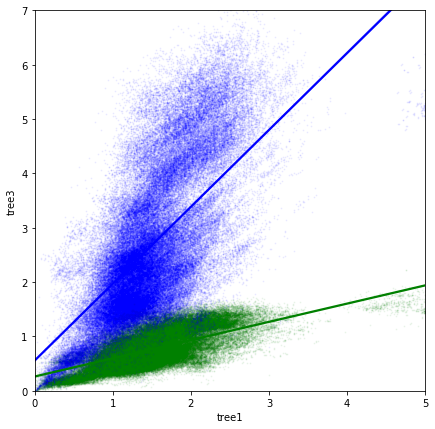

In [131]:
plot_distance_comparisons(primate_denovo_tree,
                          primate_inserted_subtree,
                          recomputed_tree, 
                          subset=500, 
                          xlim=5,
                          ylim=7)

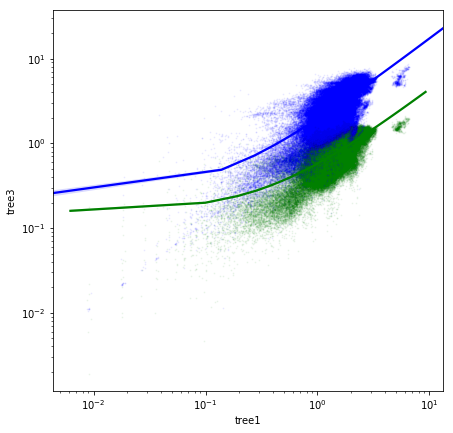

In [124]:
plot_distance_comparisons(primate_denovo_tree,
                          primate_inserted_subtree,
                          recomputed_tree, subset=500, log=True)

# Testing recapituling the GreenGenes phylogeny

there would be a couple ways to do this.

One would be to take a subset of the gg99 phylogeny, insert them into the 97 tree, and then see how close the sepp and denovo-constrained trees come to recapitulating the complete sequence phylogeny

Another would be to take one of the phylogenies and try selectively removing some tips, inserting the removed tips, and then comparing the resulting tree against the original. 